In [1]:
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import yfinance as yf
from scipy.stats import gmean

# add utils path
src_path = os.path.abspath('../../')
if src_path not in sys.path:
    sys.path.append(src_path)

# import custom functions
from src.backtest import BacktestTrader
from src.strategies import EWMAC
from src.utils import get_risk_free_rate, max_drawdown

In [2]:
START_DATE = '1999-01-21'
END_DATE = datetime.today().strftime('%Y-%m-%d')
TICKER = 'SPY'

SHORT_WINDOW = 16
LONG_WINDOW = 64

prices = yf.download(TICKER, start=START_DATE, end=END_DATE)['Adj Close']
risk_free_rate = get_risk_free_rate(START_DATE, END_DATE)

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


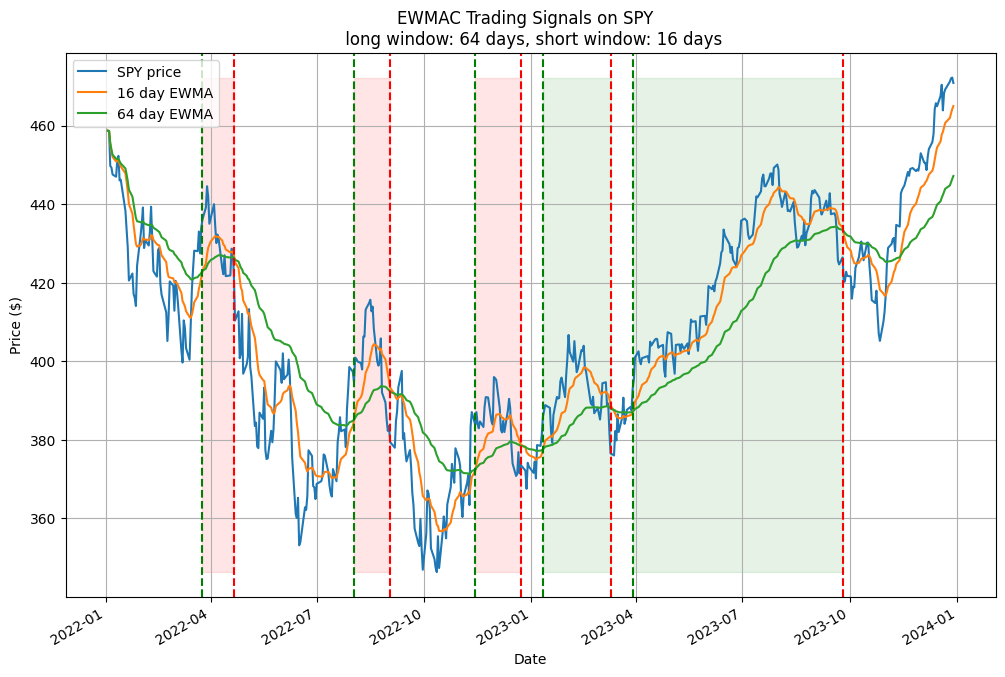

In [3]:
# example of EWMA crossover strategy
ex_data = yf.download(TICKER, start='2022-01-01', end='2023-12-31')['Adj Close']
ewma_short = ex_data.ewm(span=SHORT_WINDOW).mean()
ewma_long = ex_data.ewm(span=LONG_WINDOW).mean()

# find the crossovers
ewma_diff = ewma_short - ewma_long
crossovers = np.where(np.diff(np.sign(ewma_diff)))[0]
if ewma_diff.iloc[crossovers[1]] < 0:
    crossovers = crossovers[1:]
# add a final crossover if the last signal was a buy
if len(crossovers) % 2 == 0:
    crossovers = np.append(crossovers, len(ex_data)-1)

plt.figure(figsize=(12, 8))
plt.plot(ex_data, label=f'{TICKER} price')
ewma_short.plot(label=f'{SHORT_WINDOW} day EWMA')
ewma_long.plot(label=f'{LONG_WINDOW} day EWMA')

# plot trade windows
y_limits = [ex_data.min(), ex_data.max()]
for n in range(0, len(crossovers)-1, 2):
    plt.axvline(ex_data.index[crossovers[n]], color='g', linestyle='--')
    plt.axvline(ex_data.index[crossovers[n+1]], color='r', linestyle='--')
    
    shade_color = 'green' if ex_data.iloc[n+1] > ex_data.iloc[n] else 'red'
    plt.fill_betweenx(
        y_limits, ex_data.index[crossovers[n]],
        ex_data.index[crossovers[n+1]],
        color=shade_color,
        alpha=0.1
    )
    
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'EWMAC Trading Signals on {TICKER}  \n long window: {LONG_WINDOW} days, short window: {SHORT_WINDOW} days')
plt.legend()
plt.grid()
plt.show()

In [4]:
stock_returns = prices.pct_change().dropna()
total_returns = (prices.iloc[-1]-prices.iloc[0])/prices.iloc[0]
average_returns = gmean(np.array(stock_returns)+1)-1
annual_returns = (1+average_returns)**252 - 1
annual_std = np.std(stock_returns) * np.sqrt(252)
sharpe_ratio = (annual_returns - risk_free_rate.mean()) / annual_std
skew = stock_returns.skew()
kurtosis = stock_returns.kurtosis()
drawdown = max_drawdown(stock_returns)

stock_results = {
    'total_returns': total_returns,
    'average_returns': average_returns,
    'annual_returns': annual_returns,
    'annual_std': annual_std,
    'sharpe_ratio': sharpe_ratio,
    'skew': skew,
    'kurtosis': kurtosis,
    'max_drawdown': drawdown
}

In [5]:
print(f'Holding {TICKER}')
stock_results

Holding SPY


{'total_returns': 6.3297329176913415,
 'average_returns': 0.0003084450014543272,
 'annual_returns': 0.08081583139210546,
 'annual_std': 0.19391215690056532,
 'sharpe_ratio': 0.24394864015293155,
 'skew': -0.013142027424599408,
 'kurtosis': 11.267032745282105,
 'max_drawdown': -0.5518943077041341}

In [6]:
ewmac = EWMAC(short_window=SHORT_WINDOW, long_window=LONG_WINDOW)
ewmac_trader = BacktestTrader(ewmac, prices)
ewmac_trader.run_backtest()
ewmac_results = ewmac_trader.get_results()

In [7]:
print(f'Trading {TICKER} with EWMAC (no shorting)')
ewmac_results

Trading SPY with EWMAC (no shorting)


{'average_returns': 0.00021297716540380485,
 'annual_returns': 0.055130579413370295,
 'annual_std': 0.1160148405514543,
 'sharpe_ratio': 0.18635509190873994,
 'skew': -0.49225213463379114,
 'kurtosis': 5.596853677332774,
 'max_drawdown': -0.4009276322314759,
 'total_returns': 2.9569480922698976,
 'portfolio_value': 39569.480922698975}

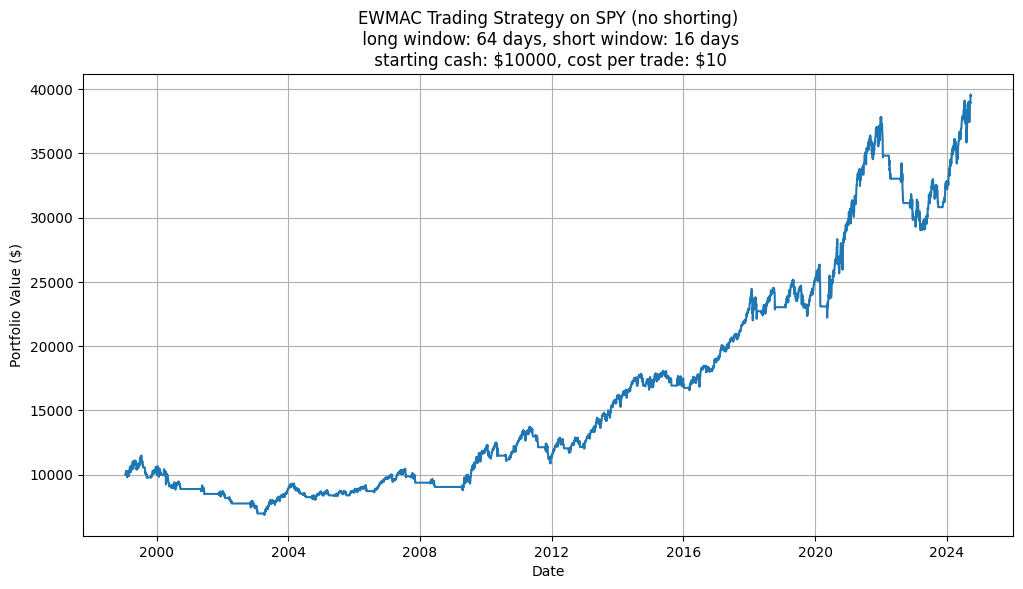

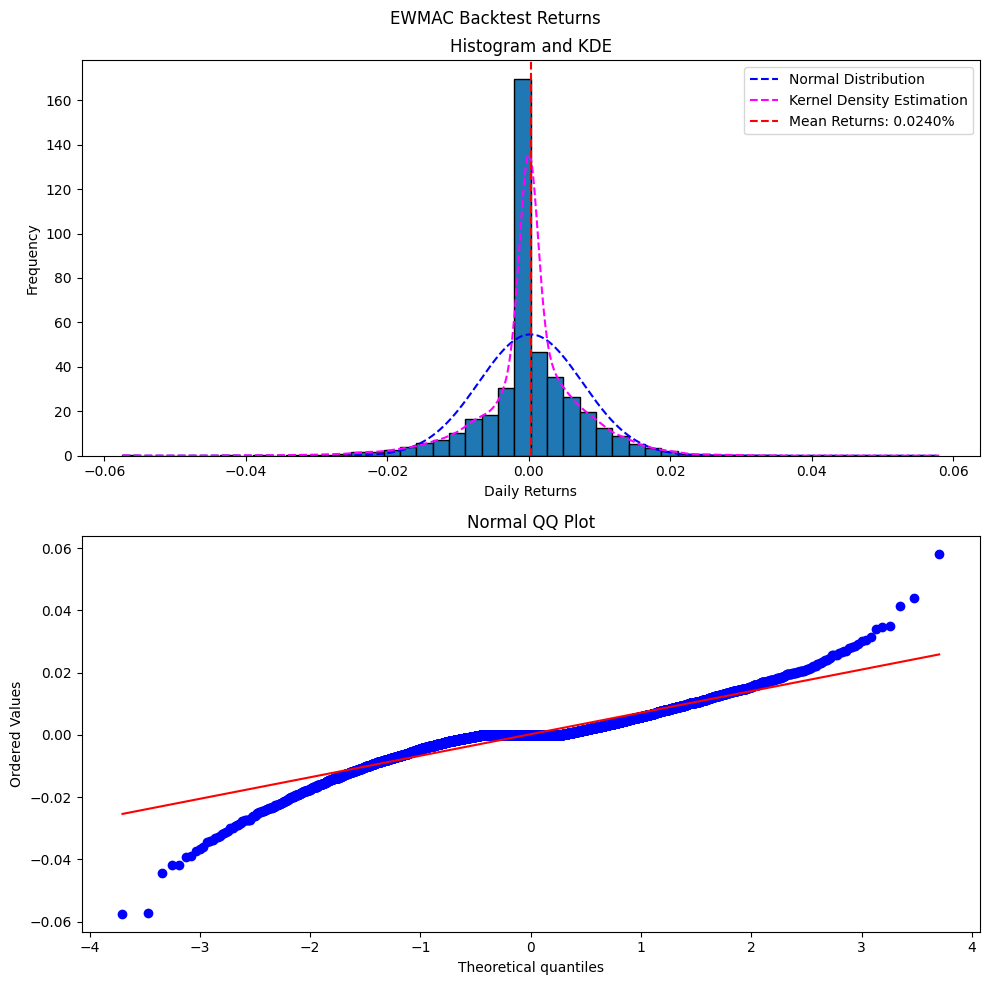

In [20]:
ewmac_trader.plot_results(
    title=(
        f'EWMAC Trading Strategy on {TICKER} (no shorting)' +
        f'\n long window: {LONG_WINDOW} days, short window: {SHORT_WINDOW} days' +
        f'\n starting cash: \$10000, cost per trade: \$10'
    )
)
ewmac_trader.plot_analysis(title='EWMAC Backtest Returns')

In [9]:
ewmac_short = EWMAC(short_window=SHORT_WINDOW, long_window=LONG_WINDOW, enable_shorting=True)
ewmac_short_trader = BacktestTrader(ewmac_short, prices)

ewmac_short_trader.run_backtest()
ewmac_short_results = ewmac_short_trader.get_results()

In [10]:
print(f'Trading {TICKER} with EWMAC (shorting enabled)')
ewmac_short_results

Trading SPY with EWMAC (shorting enabled)


{'average_returns': 4.846794747748184e-05,
 'annual_returns': 0.012288517707618851,
 'annual_std': 0.16882744886004697,
 'sharpe_ratio': -0.125702932641006,
 'skew': 0.014920540141479924,
 'kurtosis': 4.579336350296876,
 'max_drawdown': -0.5331642177928358,
 'total_returns': 0.3675856507582841,
 'portfolio_value': 13675.856507582841}

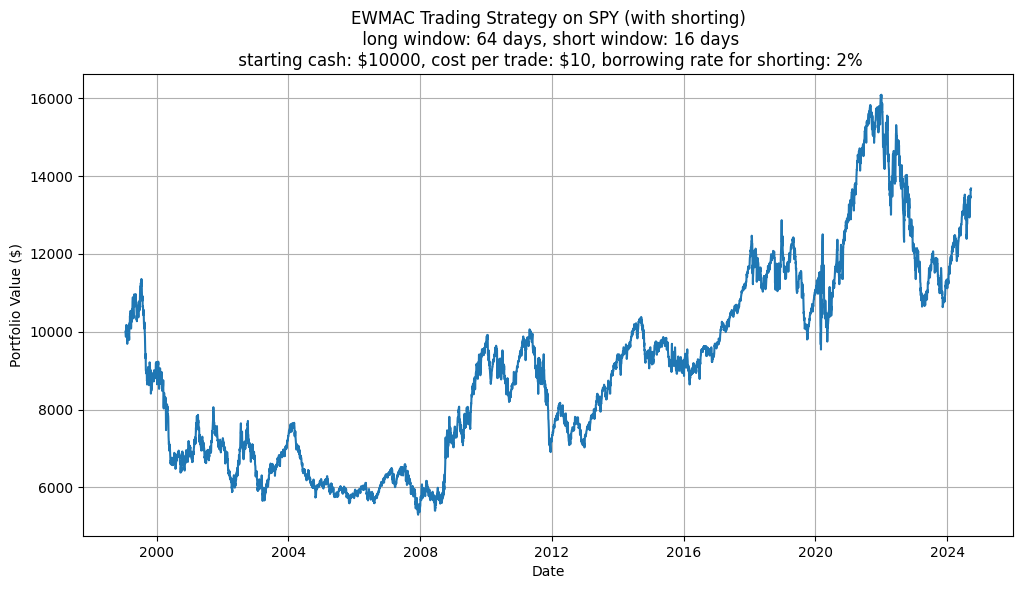

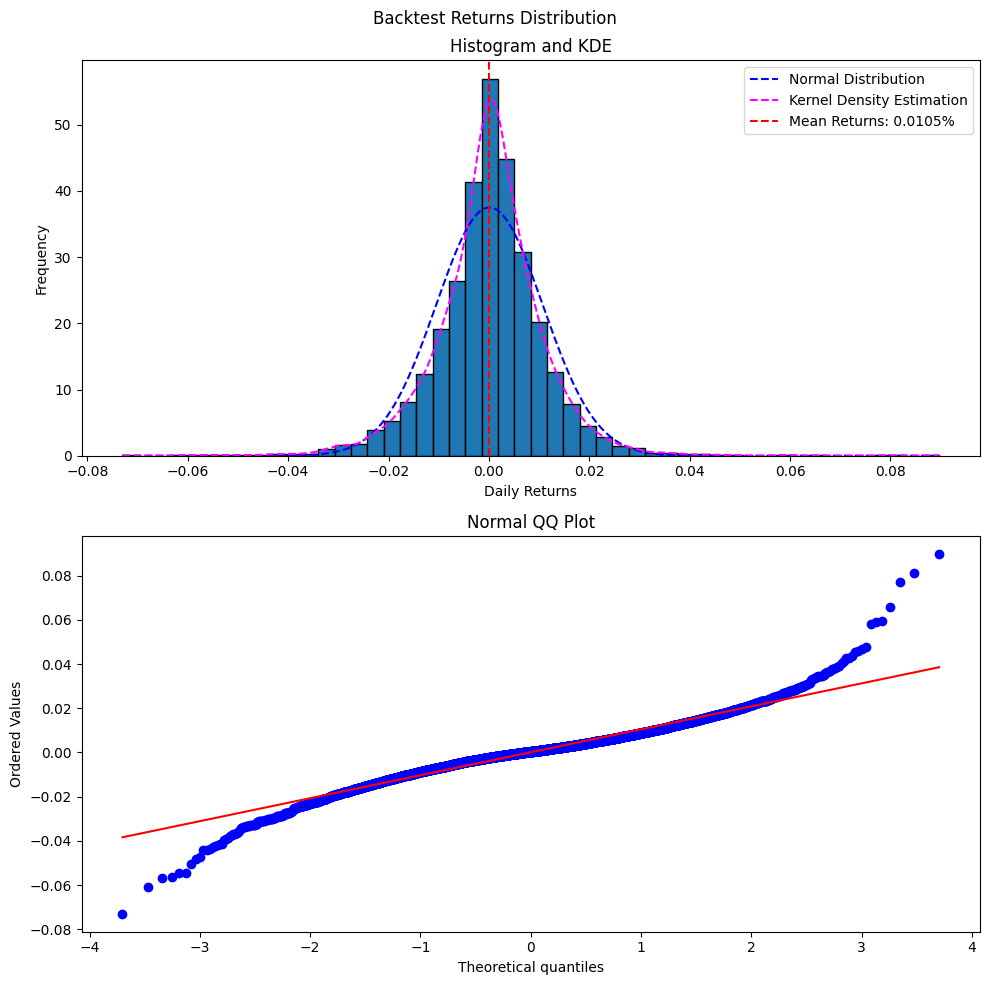

In [11]:
ewmac_short_trader.plot_results(
    title=(
        f'EWMAC Trading Strategy on {TICKER} (with shorting)' +
        f'\n long window: {LONG_WINDOW} days, short window: {SHORT_WINDOW} days'
        f'\n starting cash: \$10000, cost per trade: \$10, borrowing rate for shorting: 2%'
    )
)
ewmac_short_trader.plot_analysis(hist_bins=50)

In [12]:
# stationary bootstrap
historical_returns = prices.pct_change().dropna()
data_len = len(historical_returns)
n_iterations = 100
exp_block_len = 10
bootstrap_samples = []
sample_stats = {}

for _ in range(n_iterations):
    sample = []
    i = np.random.randint(0, data_len)
    
    while len(sample) < data_len:
        sample.append(historical_returns.iloc[i])
        
        if np.random.rand() < 1/exp_block_len:
            i = np.random.randint(0, data_len) # sample a new block
        else:
            i = (i+1) % data_len # sample next data point in block
    
    # calculate statistics for sample
    average_returns = gmean(np.array(sample)+1)-1
    annual_returns = (1+average_returns)**252 - 1
    annual_std = np.std(sample) * np.sqrt(252)
    sharpe_ratio = (annual_returns - risk_free_rate.mean()) / annual_std
    skew = pd.Series(sample).skew()
    kurtosis = pd.Series(sample).kurtosis()
    drawdown = max_drawdown(pd.Series(sample))
    
    sample_stats.setdefault('mean returns', []).append(average_returns)
    sample_stats.setdefault('annual returns', []).append(annual_returns)
    sample_stats.setdefault('annual std', []).append(annual_std)
    sample_stats.setdefault('sharpe ratio', []).append(sharpe_ratio)
    sample_stats.setdefault('skew', []).append(skew)
    sample_stats.setdefault('kurtosis', []).append(kurtosis)
    sample_stats.setdefault('max drawdown', []).append(drawdown)
    
    bootstrap_samples.append(np.array(sample))

# calculate bootstrap statistics
bootstrap_stats = pd.DataFrame(index=['mean', 'median', 'std', '95 upper', '95 lower'])
for key, value in sample_stats.items():
    ci = np.percentile(value, [2.5, 97.5])
    bootstrap_stats.loc['mean', key] = np.mean(value)
    bootstrap_stats.loc['median', key] = np.median(value)
    bootstrap_stats.loc['std', key] = np.std(value)
    bootstrap_stats.loc['95 lower', key] = ci[0]
    bootstrap_stats.loc['95 upper', key] = ci[1]

In [13]:
bootstrap_stats.T

,mean,median,std,95 upper,95 lower
mean returns,0.000317,0.000320,0.000138,0.000554,0.000044
annual returns,0.083892,0.083864,0.037675,0.149864,0.011095
annual std,0.192681,0.193287,0.009670,0.210068,0.175161
sharpe ratio,0.266362,0.272980,0.203635,0.616493,-0.112196
skew,0.012363,-0.009039,0.262974,0.565687,-0.442094
kurtosis,11.020342,11.356867,3.576133,18.182752,4.520933
max drawdown,-0.444084,-0.439902,0.101235,-0.286106,-0.665582


In [14]:
stock_results

{'total_returns': 6.3297329176913415,
 'average_returns': 0.0003084450014543272,
 'annual_returns': 0.08081583139210546,
 'annual_std': 0.19391215690056532,
 'sharpe_ratio': 0.24394864015293155,
 'skew': -0.013142027424599408,
 'kurtosis': 11.267032745282105,
 'max_drawdown': -0.5518943077041341}

In [15]:
# reconstruct price time series and calculate statistics
initial_price = prices.iloc[0]
bootstrap_prices = []
for sample in bootstrap_samples:
    sample_prices = [initial_price]
    sample_prices.extend(initial_price * (1+sample).cumprod())
    
    bootstrap_prices.append(sample_prices)

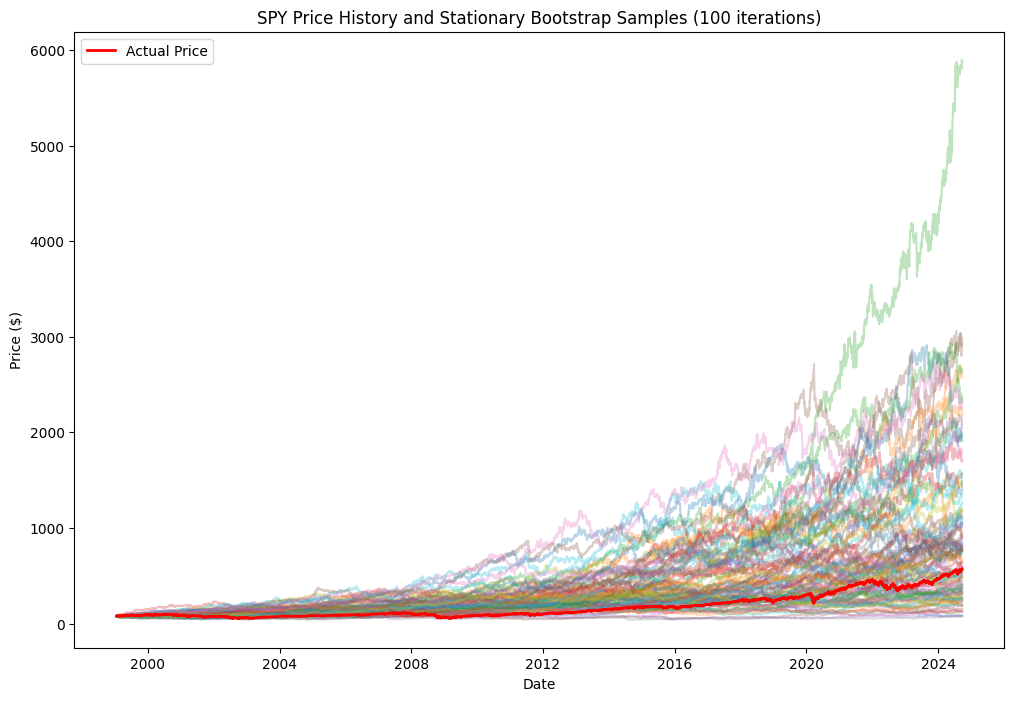

In [16]:
dates = prices.index

# plot
plt.figure(figsize=(12, 8))

for sample in bootstrap_prices:
    plt.plot(dates, sample, alpha=0.3)

plt.plot(prices, label=f'Actual Price', color='red', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'{TICKER} Price History and Stationary Bootstrap Samples ({n_iterations} iterations)')
plt.legend()
plt.show()

In [17]:
bootstrap_results = ewmac_trader.run_bootstrap(block_size=10)

In [18]:
bootstrap_results

,mean,median,std,95 upper,95 lower
average_returns,0.000160,0.000157,0.000066,0.000292,0.000041
annual_returns,0.041290,0.040465,0.017456,0.076471,0.010340
annual_std,0.150643,0.151408,0.010165,0.167783,0.129468
sharpe_ratio,0.053906,0.045381,0.119597,0.314411,-0.160732
skew,0.009217,0.047605,0.258675,0.460110,-0.526435
kurtosis,20.088008,20.988870,5.527310,29.687087,7.581911
max_drawdown,-0.487377,-0.496287,0.084232,-0.330813,-0.646795


In [19]:
ewmac_results

{'average_returns': 0.00021297716540380485,
 'annual_returns': 0.055130579413370295,
 'annual_std': 0.1160148405514543,
 'sharpe_ratio': 0.18635509190873994,
 'skew': -0.49225213463379114,
 'kurtosis': 5.596853677332774,
 'max_drawdown': -0.4009276322314759,
 'total_returns': 2.9569480922698976,
 'portfolio_value': 39569.480922698975}